# Programming exercise 7: Entanglement and the transverse field Ising model

Due on Monday, 10.12.2018, 14.15h

### Total: 100 points

In [2]:
# load standard libraries

import numpy as np   # standard numerics library
import numpy.linalg as LA

import matplotlib.pyplot as plt   # for making plots

import time as time

import scipy.sparse as sp
import scipy.sparse.linalg as sLA

from numpy import (array, pi, cos, sin, ones, size, sqrt, real, mod, append, arange)

#from qutip import (tensor, basis) 

%matplotlib inline

### Exercise 1: Building general spin 1/2 Hamiltonians (50 points)

In the past exercises we have worked with the collective Ising model, where we could use the permutation symmetry to reduce the Hilbert space dimension from $2^N$ to $N+1$. This time we want to consider a model with nearest neighbor spin interactions, the one-dimensional transverse-field Ising model (TFIM), where the permutation symmetry no longer holds. This model is analytically solvable (see e.g. https://www.sciencedirect.com/science/article/pii/0003491670902708). For the sake of learning how to build general spin models, we will solve it here by numerical means and compare the result to the exact solution as a check. The tools you develop here, you can then apply to build any spin Hamiltonian straight forwardly. The Hamiltonian of the TFIM reads
$$
H=\sum_{i=0}^{N-1} -J\sigma_z^{(i)}\sigma_z^{(i+1)} - B \sigma_x^{(i)}
$$
where we want to use __periodic boundary conditions__, i.e. the Nth spin is identified with the 0th spin.

To solve it we first set up a framework for general spin 1/2 models.
We will work in the canonical product basis of states $|i_1,...,i_N\rangle$, where $i_k \in \{0,1\}$. This basis of course has the problem of exponential scaling of the number of basis states with particle number N. But we still want to use it to keep our approach as general as possible, which then just allows us to use up to 12 or so spins with reasonable computation time.

The recipe for conctructing general spin models is the following:

1) Build the single-spin operators $s_x$, $s_y$, $s_z$, and the 2x2 identity, $\mathbb{1}$ as sparse matrices (csr_matrix should work best).

2) Build a list of all single-spin operators acting on spin $i=0...N-1$ in the $N$-spin Hilbert space.
$$
s_\alpha^{(i)} = \mathbb{1}^{\otimes i}\otimes s_\alpha \otimes \mathbb{1}^{\otimes (N-i-1)}
$$
where $\alpha \in \{x,y,z\}$. Use the kronecker product for sparse matrices to do this. (Make sure you understand how the indexing/ordering of the matrix elements is done by kron()!)

3) Build any hermititian operator (here we want the Hamiltonian) by adding up its individual terms, using the dot product for interaction terms.

Test your implementation by calculating the ground state energy of the transverse field Ising model and comparing it to the analytical result (for even $N$)
$$
E_0^{analyt} = -\sum_{k=-(N-1)/2}^{(N-1)/2}\sqrt{1+B^2 - 2B\cos(2\pi k/N)}
$$
where the convention $J=1$ was chosen.
For N=10, scan $B$ from 0 to 2 and plot the numerical and analytical result for the ground state energy.

Also think about what the ground state should be at large $B$ and at $B=0$. 

In [55]:
# 1)
# spin matrices as sparse matrices
s = [sp.csr_matrix(np.array([[0, 1]  ,[ 1, 0]])/2),    #sx
     sp.csr_matrix(np.array([[0, -1j],[1j, 0]])/2),    #sy
     sp.csr_matrix(np.array([[1, 0]  ,[0, -1]])/2)]    #sz
one = sp.identity(2,format='csr') #sparse matrix of 2x2 identity

# 2)
#function to compute N kronecker products of identities with 2x2 matrices at certain indices
def NKron(N,matrices=[],indices=[]):
    result=matrices[0] if 0 in indices else one
    for i in range(1,N):
        result=sp.kron(result,matrices[indices.index(i)] if i in indices else one)
    return result
#returns s_\alpha^(i)
def singleSpin(N,alpha,i):
    return NKron(N,[s[alpha]],[i])
#now create a list of all single spin operators 
# 3)
#build the Hamiltonian
def H(N,B,J=1):
    Hmat=np.zeros((2**N,2**N))
    for i in range(N):
        Hmat+=-J*singleSpin(N,2,i)@singleSpin(N,2,i+1)-B*singleSpin(N,0,i)
    return Hmat
#ground state engergy of the transverse field Ising model:
def E0_analyt(N,B):
    if N%2==1:
        raise ValueError('N needs to be even')
    E=0
    for k in range(int(-N/2+.5),int(N/2-.5)):
        E+=sqrt(1+B**2-2*B*cos(2*pi*k/N))
    return -E
#numerical computation of the ground state energy
def E0_numeric(N,B):
    Hmat=H(N,B)
    evals,evecs=sLA.eigs(Hmat,k=1,which='SR')
    return evals[0]

In [53]:
N=6
BSpace=np.linspace(0,2,10)
energy=np.zeros((len(BSpace),2)) #store all energies in this array
for i in range(len(BSpace)):
    B=BSpace[i]
    energy[i,0]=E0_analyt(N,B)
    energy[i,1]=E0_numeric(N,B)
    

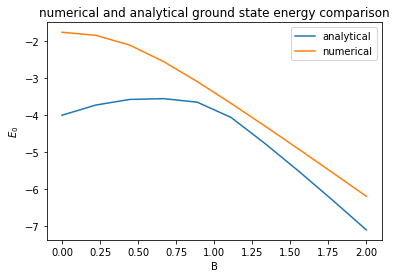

In [54]:
plt.plot(BSpace,energy[:,0],label='analytical')
plt.plot(BSpace,energy[:,1],label='numerical')
plt.xlabel('B')
plt.ylabel('$E_0$')
plt.title('numerical and analytical ground state energy comparison')
plt.legend()

### Exercise 2: Taking partial traces (50 points)

The TFIM has a quantum phase transition at $B/J=1$ from a ferromagnetic to a paramagnetic phase. You can use your code from exercise 1 to see that the gap is mimimal around this value. Note that the model also has the $Z_2$ symmetry (invariance under flipping of all spins) which we saw in the collective Ising model, so you would look at the gap of ground and second excited state.
At the phase transition point, long-range correlations emerge in the ground state. An interesting feature is also that at the critical point the half-chain entanglement entropy diverges logarithmically as $N$ goes to infinity (see for example https://arxiv.org/abs/0803.3610 Fig. 3). For finite $N$ we should already see that the entanglement entropy becomes maximal approximately at the critical point.

To calculate the half-chain entanglement entropy in the ground state of the transverse Ising chain, you should proceed as follows:

1) Divide the chain into two halves and calculate the reduced state of one half, i.e., calculate the partial trace over the first or the last $N/2$ spins. The matrix element of the reduced density of a state $|\psi\rangle = \sum_i c_i |i\rangle$ (where $|i\rangle$ are the $N$-spin basis states) traced over spins $N/2$ thorugh $N-1$, i.e. over the second half, can be expressed as
$$
(\rho_{red,N/2})_{ij} = \sum_{k=0}^{2^{N/2}-1} c_{i+k*2^{N/2}}c_{j+k*2^{N/2}}
$$
(This might look different depending on how the states are ordered in your basis.)

2) Calculate the eigenvalues $p_i$ of $\rho_{red,N/2}$, sort them from largest to smallest. This is the entanglement spectrum. The rank of $\rho_{red,N/2}$ is called entanglement dimension. For a separable state the entanglement dimension is 1, i.e. only one eigenvalue is non-zero.

3) Calculate the von-Neumann entanglement entropy $S_E = -\sum_i p_i \log(p_i)$. Consider that some of the eigenvalues can be zero. Due to the finite numerical precision they can even turn negative. These you want to exclude from the sum. (The limit $\lim_{p\rightarrow 0} p\log(p) =0$ so we are not actually modifying the outcome significantly by neglecting small p's.)

Test your code for some cases where you know the answer, for example a separable state or a Bell pair state of 2 qubits. The qutip module also has the capability of calculating partial traces. If you are interested you can compare to this for testing.

Then calcualte the entanglement spectrum and entropy for the same parameter scan as in exercise 1. Document your observations.

### Optional Exercise 3: Time-dependence of entanglement entropy

Calculate the time-evolution for all spins being in the state $|+\rangle = (|0\rangle+|1\rangle)/\sqrt{2}$ initially.

If you evolve this state with the critical Ising Hamiltonian, the enatnglement entropy should increase very rapidly in time and saturate due to the finite system size. The saturation value is extensive in system size (volume law). This makes simulating the time evolution for quenches near the critical point challenging for techniques based on matrix prduct states (next lecture). 

### Optional Exercise 4: Spin squeezing and entanglement

Let us look at the collective Ising spin-model with a transverse field one last time. The Hamiltonian is still
$$
H=-\frac{J}{N}S_z^2 - \Omega S_x
$$
with the collective spin operators $S_\alpha = \sum_i \sigma_i^\alpha/2$, where $\sigma_i^\alpha$ is a Pauli operator acting on spin $i$. This time we want to examine how spin squeezed states form under the dynamics of this model. All we have to do is to initialize the system with all spins pointing along the x-direction, i.e. in the coehrent spin state $|CSS(\pi/2,0)\rangle$. For any small value of $\Omega$ (we can actually choose $\Omega=0$) we will observe spin squeezing.
Plot the Husimi distribution of the state using the "front view" form programming exercise 6 and observe how it evolves with time. Evaluate $S_x$ and the variance in any direction perpendicular to $S_x$ by rotating the state about the x-axis and calculating the variance of $S_z$ to determine the direction of maximal squeezing.

Calculate the optimal squeezing parameter $\min_{\mathbf{n}_\perp} = N (\Delta (\mathbf{n}_\perp\cdot \mathbf{S}))^2/\langle S_x\rangle^2$ as a function of time. Whay does it increase again after some time?

Spin squeezing is associated with the buildup of entanglement. Calculate the entanglement entropy for the above time evolution. You can use the techniques from exercises 1 and 2 for this and solve the collective Ising model in the product basis, which of course allows you only to go to small numbers of spins, but the effects will still be visible. Note that one can also calculate the reduced density using symmetrized Dicke states (see https://arxiv.org/abs/cond-mat/0409611). You can implement this as a cross check and for going to larger N.